In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from tqdm import tqdm

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2, T = 100):
        """
        input_dim: dimension of input (x and t concatenated)
        output_dim: dimension of output (drift term)
        """
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.time_emb = nn.Embedding(T, 32)
    
    def forward(self, x, t):
        """
        x: Tensor of shape (batch_size, 2)
        t: Tensor of shape (batch_size, 1)
        """
        # Concatenate x and t
        # print(x.shape, self.time_emb(t).shape)
        xt = torch.cat([x, self.time_emb(t)], dim=-1)  # Shape: (batch_size, 3)
        return self.net(xt)

In [62]:
class SchrödingerBridgeDataset(Dataset):
    def __init__(self, initial_samples: int, final_samples: int):
        """
        Args:
            initial_samples (int): Number of samples from the initial distribution.
            final_samples (int): Number of samples from the final distribution.
        """
        super(SchrödingerBridgeDataset, self).__init__()
        
        self.final_data = self.uniform_distribution(final_samples) + 8
        self.initial_data = self.bimodal_distribution(final_samples)
        # self.initial_data = torch.randn((final_samples, 1))
        # random_index = torch.randperm(len(self.final_data))
        # self.final_data = torch.randn((final_samples, 1))*2 - 3
    @staticmethod
    def uniform_distribution(batch_size: int) -> torch.Tensor:
        """
        Uniform distribution in [-1, 1] x [-1, 1].
        """
        return torch.rand(batch_size, 1) * 2 - 1  # Shape: (batch_size, 2)
    
    @staticmethod
    def bimodal_distribution(batch_size: int) -> torch.Tensor:
        """
        Bimodal distribution with two Gaussian clusters.
        """
        half = batch_size // 2
        cluster1 = torch.randn(half, 1) + 2.0  # Cluster centered at (2)
        cluster2 = torch.randn(batch_size - half, 1) - 2.0  # Cluster centered at (-2)
        return torch.cat([cluster1, cluster2], dim=0)  # Shape: (batch_size, 1)
    
    def __len__(self):
        # Total samples are from both initial and final distributions
        return max(len(self.initial_data), len(self.final_data))
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of (x_initial, x_final).
        If one distribution has fewer samples, wrap around using modulo.
        """
        x_initial = self.initial_data[idx % len(self.initial_data)]
        x_final = self.final_data[idx % len(self.final_data)]
        return {"x0": x_initial, "xT":x_final}
    def plot(self):
        bins = np.linspace(-5, 5, 100)
        plt.hist(self.initial_data.detach().numpy(), bins = bins, alpha = 0.3, label = "inital_distribution")
        plt.hist(self.final_data.detach().numpy(), bins = bins, alpha = 0.3, label = "final_distribution")
        plt.legend()
        plt.grid()
        plt.show()
        

In [63]:
def lagevin(x:torch.Tensor, model:nn.Module, T:int, gamma:torch.Tensor, device = "cuda:0", reversed = False):
    traj_x = [x.unsqueeze(-1).detach().cpu()]
    grad_all = []
    model.eval()
    model.to(device)
    t = np.arange(0, T)
    t = t[::-1] if reversed else t
    gamma = gamma.to(device)
    xk = x
    for i in t:
        time = int(i)*torch.ones((xk.shape[0],)).to(device).to(torch.int64)
        # print(xk.shape, time.shape)
        xk = xk.to(device)
        if reversed:
            xk = xk - model(xk, time) + torch.sqrt(2*gamma[i]/T)*torch.randn_like(xk, device = device, dtype=torch.float32)
        else:
            xk = xk + model(xk, time) + torch.sqrt(2*gamma[i]/T)*torch.randn_like(xk, device = device, dtype=torch.float32)
        traj_x.append(xk.unsqueeze(-1).detach().cpu())
        grad_all.append(traj_x[-1] - traj_x[-2])
    x_all = torch.cat(traj_x, dim = -1)
    grad_all = torch.cat(grad_all, dim = -1)
    return x_all, grad_all

In [64]:
def simple_dsb(dataset, batch_size, epoches, inner_epoches, f_model, b_model,f_optim, b_optim, sigma, T, device):
    dl = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
    outer_pbar = tqdm(range(epoches), desc=f"Epoch", leave=False)
    sigma = sigma.to(device)
    total_loss_f = []
    total_loss_b = []
    forward_generated = []
    backward_generated = []
    b_model.train()
    f_model.eval()
    f_model, b_model = f_model.to(device), b_model.to(device)
    
    for epoch in outer_pbar:
        epoch_loss_b = 0
        epoch_loss_f = 0
        # train the backward process 
        for _ in tqdm(range(inner_epoches), desc="Backward Inner Epoch", leave=False):
            f_model.eval()
            b_model.train()
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                sample_t = torch.randint(high = T, low = 1, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
                with torch.no_grad():
                    x_all, grad_all = lagevin(x0, f_model, T = T, gamma=sigma, device = device, reversed=False)
                
                # x_all = 
                sample_xk = torch.gather(x_all, dim = -1, index = sample_t + 1).to(device)
                grad_out = torch.gather(grad_all, dim = -1, index = sample_t).to(device)
                pred_out = b_model(sample_xk.to(device), (sample_t).to(device).squeeze(-1))
                # pred_out = b_model(sample_xk.to(device), (T - sample_t - 1).to(device).squeeze(-1))
                
                b_optim.zero_grad()
                loss_b = nn.functional.mse_loss(input = pred_out, target= grad_out)
                loss_b.backward()
                torch.nn.utils.clip_grad_norm_(b_model.parameters(), 1)
                b_optim.step()
                epoch_loss_b += loss_b.item()
            forward_generated.append(x_all[:, 0, -1])
        total_loss_b.append(epoch_loss_b/len(dl)) 
        for _ in tqdm(range(inner_epoches), desc="Forward Inner Epoch", leave=False):
            b_model.eval()
            f_model.train()
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                sample_t = torch.randint(high = T-1, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
                with torch.no_grad():
                    x_all, grad_all = lagevin(xT, b_model, T = T, gamma=sigma, device = device, reversed=True)
                sample_xk = torch.gather(x_all, dim = -1, index = T - sample_t).to(device)
                grad_out = torch.gather(grad_all, dim = -1, index = T - sample_t - 1).to(device)
                pred_out = f_model(sample_xk, sample_t.to(device).squeeze(-1)) 
                # pred_out = f_model(sample_xk, (sample_t).to(device).squeeze(-1)) 
                f_optim.zero_grad()
                loss_f = nn.functional.mse_loss(input = pred_out, target= -grad_out)
                loss_f.backward()
                torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
                f_optim.step()
                epoch_loss_f += loss_f.item()
            backward_generated.append(x_all[:, 0, -1])
        total_loss_f.append(epoch_loss_f/len(dl))
    plt.plot(total_loss_f) 
    plt.plot(total_loss_b) 
    
    # plt.plot(total_loss_b)
    # plt.show()
    return f_model, b_model, {"forward_gen":forward_generated, "backward_gen":backward_generated}

In [65]:
# def simple_dsb(dataset, batch_size, epoches, inner_epoches, f_model, b_model,f_optim, b_optim, sigma, T, device):
#     dl = DataLoader(dataset=dataset, batch_size=batch_size)
#     inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
#     outer_pbar = tqdm(range(epoches), desc=f"Epoch", leave=False)
#     sigma = sigma.to(device)
#     total_loss_f = []
#     total_loss_b = []
#     forward_generated = []
#     backward_generated = []
#     f_model.train()
#     b_model.eval()
#     f_model, b_model = f_model.to(device), b_model.to(device)
    
#     for epoch in outer_pbar:
#         epoch_loss_b = 0
#         epoch_loss_f = 0
#         # train the backward process 
#         inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
#         for inner_epoch in inner_pbar:
#             f_model.eval()
#             b_model.train()
#             for data in dl:
#                 x0, xT = data['x0'].to(device), data["xT"].to(device)
#                 sample_t = torch.randint(high = T, low = 1, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
#                 with torch.no_grad():
#                     x_all, grad_all = lagevin(x0, f_model, T = T, gamma=sigma, device = device, reversed=True)
                
#                 sample_xk = torch.gather(x_all, dim = -1, index = T - sample_t).to(device)
#                 grad_out = torch.gather(grad_all, dim = -1, index = T - sample_t).to(device)
#                 pred_out = b_model(sample_xk.to(device), (sample_t).to(device).squeeze(-1))
#                 b_optim.zero_grad()
#                 loss_b = nn.functional.mse_loss(input = pred_out, target= grad_out)
#                 loss_b.backward()
#                 torch.nn.utils.clip_grad_norm_(b_model.parameters(), 1)
#                 b_optim.step()
#                 epoch_loss_b += loss_b.item()
#             forward_generated.append(x_all[:, 0, -1])
#         total_loss_b.append(epoch_loss_b/len(dl)) 
#         inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
#         for inner_epoch in inner_pbar:
#             b_model.eval()
#             f_model.train()
#             for data in dl:
#                 x0, xT = data['x0'].to(device), data["xT"].to(device)
#                 sample_t = torch.randint(high = T-1, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
#                 with torch.no_grad():
#                     x_all, grad_all = lagevin(xT, f_model, T = T, gamma=sigma, device = device, reversed=False)
#                 sample_xk = torch.gather(x_all, dim = -1, index = sample_t).to(device)
#                 grad_out = torch.gather(grad_all, dim = -1, index = sample_t).to(device)
#                 pred_out = f_model(sample_xk, sample_t.to(device).squeeze(-1))
#                 f_model.zero_grad()
#                 loss_f = nn.functional.mse_loss(input = pred_out, target= grad_out)
#                 loss_f.backward()
#                 torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
#                 f_optim.step()
#                 epoch_loss_f += loss_f.item()
#             backward_generated.append(x_all[:, 0, -1])
#         total_loss_f.append(epoch_loss_f/len(dl))
#     plt.plot(total_loss_f) 
#     plt.plot(total_loss_b) 
#     return f_model, b_model, {"forward_gen":forward_generated, "backward_gen":backward_generated}

In [66]:
ds = SchrödingerBridgeDataset(50000, 50000)

In [67]:
# ds.plot()

torch.Size([100, 1])


inner epoch:   0%|          | 0/6 [00:00<?, ?it/s]































































































































































































































































































































inner epoch:   0%|          | 0/6 [03:13<?, ?it/s]


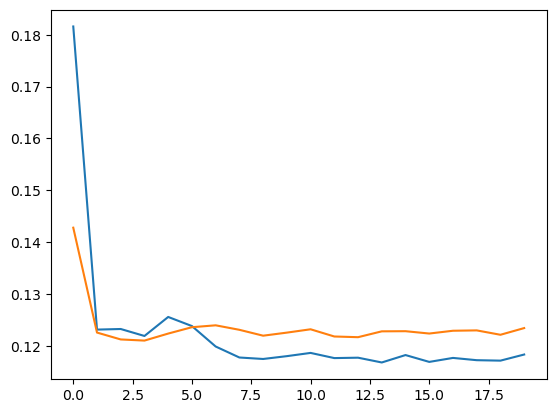

In [68]:
ds = SchrödingerBridgeDataset(10000, 10000)
T = 100
f_model = MLP(1, 256, 1, T)
b_model = MLP(1, 256, 1, T)
f_optim = torch.optim.Adam(f_model.parameters())
b_optim = torch.optim.Adam(b_model.parameters())
device = "cpu"
# sigma = torch.from_numpy(np.concatenate([np.linspace(0, 1, int(T/2))*1e-1, (np.linspace(0, 1, int(T/2))[::-1])*1e-1])).unsqueeze(-1).to(torch.float32)
sigma = torch.ones((T,1))
print(sigma.shape)
f_model, b_model, info = simple_dsb(dataset=ds, batch_size=5000, epoches = 20, inner_epoches=6, f_model = f_model, b_model = b_model, f_optim = f_optim, b_optim = b_optim, sigma = sigma, T = T, device = device)


In [75]:
# print(sigma)

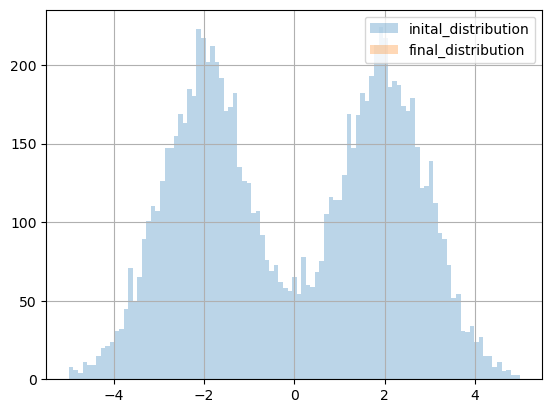

In [76]:
# print(len(info['forward_gen']))
ds.plot()

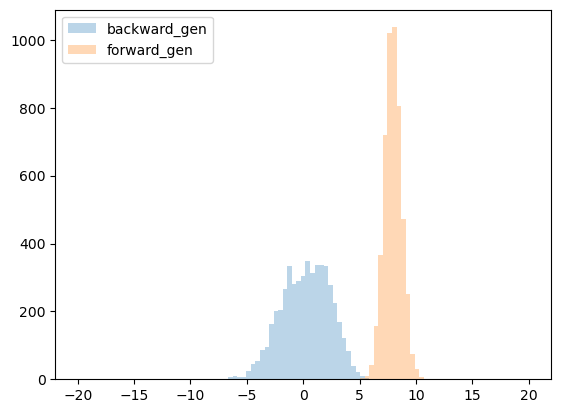

In [77]:
index = -1
bins = np.linspace(-20, 20, 100)
plt.hist(info['backward_gen'][index], bins = bins, alpha = 0.3, label= "backward_gen")
plt.hist(info['forward_gen'][index], bins = bins, alpha = 0.3, label= "forward_gen")
plt.legend()
plt.show()

In [81]:
x0, xT = next(iter(DataLoader(ds, batch_size=1000, shuffle=True)))['x0'], next(iter(DataLoader(ds, batch_size=1000, shuffle=True)))['xT']
f_gen, f_drift = lagevin(x0, f_model, T, sigma, device, reversed=False)
b_gen, b_drift = lagevin(xT, b_model, T, sigma, device, reversed=True)


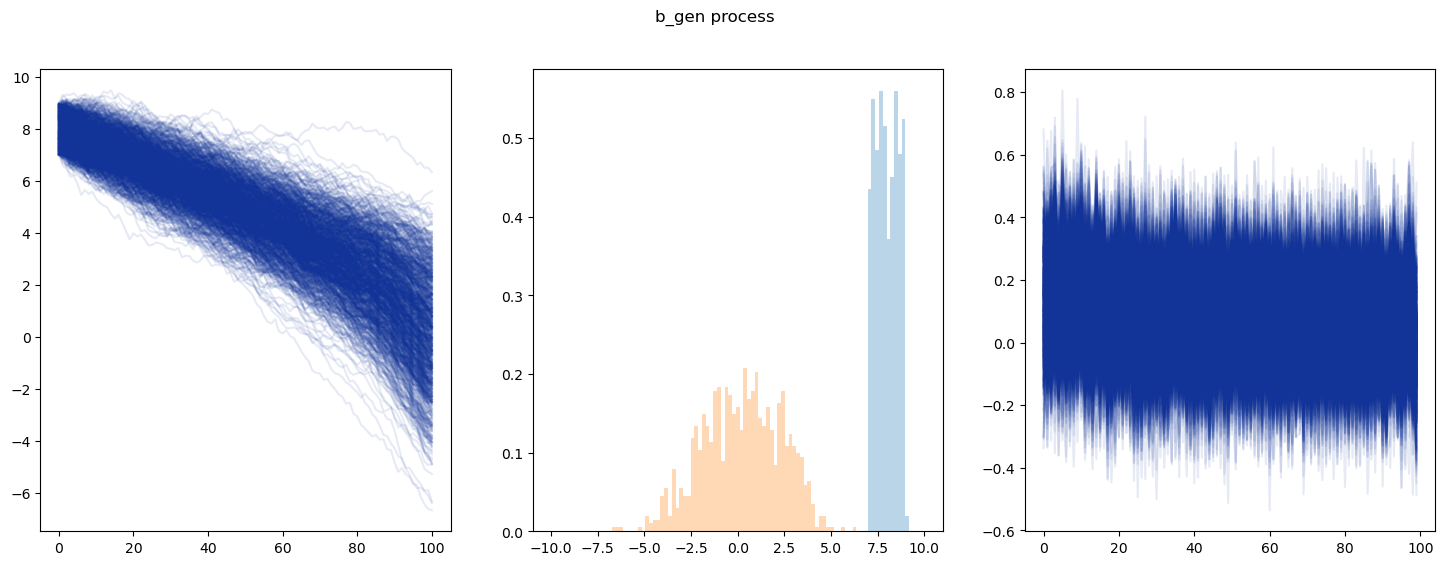

In [82]:
bins = np.linspace(-10, 10, 100)
fig, ax = plt.subplots(1,3, figsize = (6*3, 6))
for i in range(0, len(f_gen)):
    ax[0].plot(b_gen[i, 0, :], color = "#123499", alpha = 0.1)
ax[1].hist(b_gen[:, 0, 0], bins = bins, density= True, alpha = 0.3)
ax[1].hist(b_gen[:, 0, -1], bins = bins, density=True, alpha = 0.3)
for i in range(0, len(b_gen)):
    ax[2].plot(f_drift[i, 0, :], color = "#123499", alpha = 0.1)
fig.suptitle("b_gen process")
plt.show()

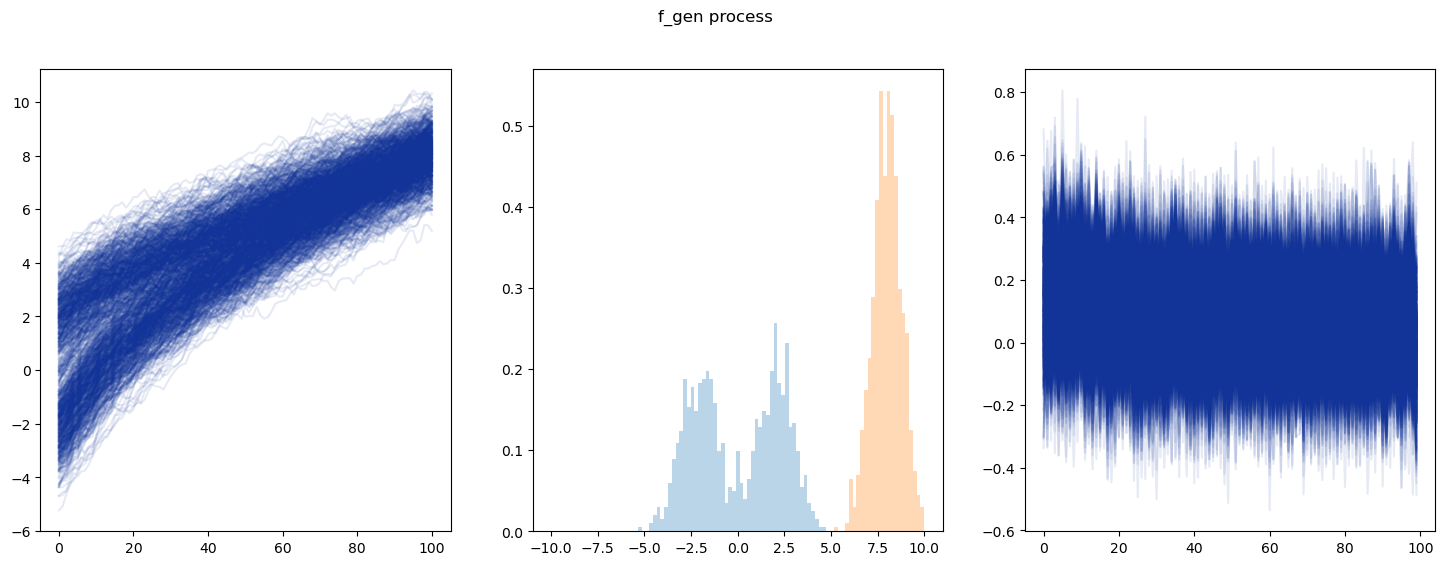

In [83]:
bins = np.linspace(-10, 10, 100)
fig, ax = plt.subplots(1,3, figsize = (6*3, 6))
for i in range(0, len(f_gen)):
    ax[0].plot(f_gen[i, 0, :], color = "#123499", alpha = 0.1)
ax[1].hist(f_gen[:, 0, 0], bins = bins, density= True, alpha = 0.3)
ax[1].hist(f_gen[:, 0, -1], bins = bins, density=True, alpha = 0.3)
for i in range(0, len(f_gen)):
    ax[2].plot(f_drift[i, 0, :], color = "#123499", alpha = 0.1)
fig.suptitle("f_gen process")
plt.show()

In [ ]:
class ZeroDriftModel(nn.Module):
    def __init__(self, dim):
        super(ZeroDriftModel, self).__init__()
        self.constant = nn.Parameter(torch.zeros(dim), requires_grad=False)

    def forward(self, x, t):
        return self.constant.expand_as(x)

# Initialize model
dim = 1
model_zero = ZeroDriftModel(dim).to(device)

# Define gamma
T = 100
gamma = torch.ones(T, 1)  # Constant noise scaling

# Initialize x0
batch_size = 100
x0 = torch.randn(batch_size, dim).to(device) + 2

# Simulate trajectories
x_all_zero, grad_all_zero = lagevin(x0, model_zero, T, gamma, device=device, reversed=False)

# Plot trajectories
for b in range(batch_size):
    # for d in range(dim):
        plt.plot(x_all_zero[b, 0, :].numpy(), color = "#123499", alpha = 0.1)
# plt.legend()
plt.title("Trajectories with Zero Drift (Pure Diffusion)")
plt.xlabel("Time Step")
plt.ylabel("State Value")
plt.show()

In [ ]:
class ConstantDriftModel(nn.Module):
    def __init__(self, dim, drift_value=0.1):
        super(ConstantDriftModel, self).__init__()
        self.drift = nn.Parameter(torch.full((dim,), drift_value))

    def forward(self, x, t):
        return self.drift.expand_as(x)

# Initialize model
model_constant = ConstantDriftModel(dim, drift_value=-0.1).to(device)

# Simulate trajectories
x_all_constant, grad_all_constant = lagevin(x0, model_constant, T, gamma, device=device, reversed=False)

# Plot trajectories
for b in range(batch_size):
        plt.plot(x_all_constant[b, 0, :].numpy(), color = "#123499", alpha = 0.1)
plt.legend()
plt.title("Trajectories with Constant Drift")
plt.xlabel("Time Step")
plt.ylabel("State Value")
plt.show()